## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBBBBB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
564
+-------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|            coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|               res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+-------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|-13331.244708510407|-1583.696829368481| -53.52425396995553|   3442.4|SSSBBBBB| 39.3672|-106.1897|       SNWD|0.04387865640581933|0.03513077704159288| 0.03533499252117007|0.

In [95]:
#extract longitude and latitude for each station
feature='coeff_3'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_3 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_3|
+-----------+--------+---------+---------+-------------------+
|USC00051660| 39.3672|-106.1897|   3442.4| -53.52425396995553|
|USC00050674|    39.8|-105.7833|   3448.2|-223.28860585502292|
|USC00051660| 39.3672|-106.1897|   3442.4| -399.2338386839257|
|USC00050674|    39.8|-105.7833|   3448.2|-1917.0458272662077|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [96]:
Query1="SELECT max(latitude),max(longitude),min(latitude),min(longitude) FROM weather"
print(Query1)
df_3 = sqlContext.sql(Query1)
df_3.show()

SELECT max(latitude),max(longitude),min(latitude),min(longitude) FROM weather
+-------------+--------------+-------------+--------------+
|max(latitude)|max(longitude)|min(latitude)|min(longitude)|
+-------------+--------------+-------------+--------------+
|      39.8143|     -105.1208|      39.1014|     -108.7339|
+-------------+--------------+-------------+--------------+



In [97]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_3)
18,US1COEG0008,39.7332,-106.6806,2201.9,1,-591.091511
1,US1COGL0013,39.7961,-105.4192,2734.7,1,-465.507297


In [98]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#ff9c00'

In [99]:
pdf['avg(coeff_3)']

18    -591.091511
1     -465.507297
4      619.671875
10    -559.675395
7     1882.582087
23    1521.476610
33    1146.618458
28    1337.760598
24    2386.049521
36    -474.414423
17    -822.161788
41    -358.234141
16     -91.461864
37     619.953097
45    1168.852488
52     948.940813
5     -570.600741
47      18.809882
26     530.955285
27    -254.192174
35     -44.554668
15    -520.978402
6    -3055.530553
29     769.639838
22    -204.970976
44      75.654828
2     -166.075613
14    -355.648691
25      16.118550
50    -382.033656
9      434.722219
40      94.228586
46    -852.727076
19    -147.893482
54     173.283926
31    -479.212294
0     -569.291821
55    -441.521377
49     256.350839
20     207.203680
34     799.204266
21    1258.320230
53     584.338955
30    -517.619098
13    -111.712362
43    -428.451121
3     -706.276504
39    -468.269392
11    -318.196761
32    -701.108259
8     -589.620507
48    1039.933707
12     111.529368
42     433.133164
51    -276.962568
38     233

## Map

In [10]:
min_lat,max_lat,min_long,max_long = box = (39.1014, 39.8143, -108.7339, -105.1208)

In [100]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    print _coef
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    #c.add_traits()
    circles.append(c)
    m.add_layer(c) 

label = ipyw.Label(layout=ipyw.Layout(width='100%'))    
    
def hover_handler(event=None, id=None, properties=None):
    label.value = pdf['avg(coeff_3)']
    
m

-591.09151063
-465.50729671
619.671875257
-559.675394867
1882.58208659
1521.47660959
1146.61845843
1337.76059763
2386.04952135
-474.414423054
-822.161787676
-358.234140951
-91.4618640158
619.953097305
1168.85248827
948.940812939
-570.600741319
18.8098818234
530.955285337
-254.192173591
-44.5546675193
-520.978401537
-3055.53055302
769.639838452
-204.970976429
75.6548278503
-166.075612987
-355.64869065
16.1185495373
-382.033656383
434.722218744
94.2285855023
-852.727076462
-147.893481665
173.283926195
-479.212293826
-569.291821365
-441.521376744
256.350838539
207.203680353
799.204266317
1258.32022977
584.338954913
-517.619098365
-111.712362173
-428.451120618
-706.276503694
-468.269391929
-318.196761186
-701.108259329
-589.620507026
1039.93370716
111.529368068
433.133163652
-276.962568369
233.166089946


In [43]:
Circle?

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

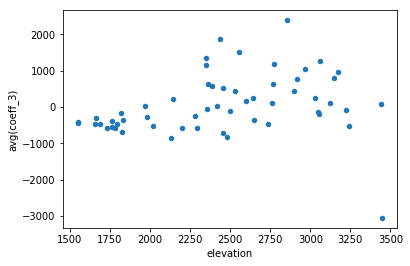

In [38]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_3)');

In [13]:
##sc.stop()

In [51]:
import ipyleaflet as ipyl
import ipywidgets as ipyw
import json

In [15]:
# Map and label widgets
map = ipyl.Map(center=[53.88, 27.45], zoom=4)
label = ipyw.Label(layout=ipyw.Layout(width='100%'))

# geojson layer with hover handler
with open('./europe_110.geo.json') as f:
    data = json.load(f)
for feature in data['features']:
    feature['properties']['style'] = {
        'color': 'grey',
        'weight': 1,
        'fillColor': 'grey',
        'fillOpacity': 0.5
    }
layer = ipyl.GeoJSON(data=data, hover_style={'fillColor': 'red'})

def hover_handler(event=None, id=None, properties=None):
    label.value = properties['geounit']

layer.on_hover(hover_handler)
map.add_layer(layer)


ipyw.VBox([map, label])